# Modèles d'apprentissage

__[III Modèles](#III-Modèles)__\
[III.1 Chargement et préparation du jeu de données](#III.1-Chargement-et-préparation-du-jeu-de-données)\
[III.2 Baseline: Régression linéaire simple](#III.2-Baseline:-Régression-linéaire-simple)\
[III.3 kNN](#III.3-kNN)\
[III.4 Régression polynomiale et sélection de prédicteurs avec Lasso](#III.4-Régression-polynomiale-et-sélection-de-prédicteurs-avec-Lasso)\
[III.5 Feature importance avec RandomForest](#III.5-Feature-importance-avec-RandomForest)\
__[IV Choix du modèle](#IV-Choix-du-modèle)__\
__[V ENERGYSTARScore](#V-ENERGYSTARScore)__\
__[VI Prédiction de TotalGHGEmission](#VI-Prédiction-de-TotalGHGEmissions)__



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno

# III Modèles
## III.1 Chargement et préparation du jeu de données

In [2]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

set_config(display='diagram')

Chargement du jeu de données nettoyé et préparé pour l'apprentissage

In [3]:
SEUmodel = pd.read_csv("./SEUmodel2.csv")
GHGmodel = pd.read_csv("./GHGmodel2.csv")
SEUmodel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1846 entries, 0 to 3375
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     1846 non-null   object 
 1   PrimaryPropertyType              1846 non-null   object 
 2   YearBuilt                        1846 non-null   int64  
 3   NumberofBuildings                1846 non-null   float64
 4   NumberofFloors                   1846 non-null   float64
 5   PropertyGFATotal                 1846 non-null   int64  
 6   PropertyGFAParking               1846 non-null   int64  
 7   PropertyGFABuilding(s)           1846 non-null   int64  
 8   LargestPropertyUseType           1846 non-null   object 
 9   LargestPropertyUseTypeGFA        1846 non-null   float64
 10  SecondLargestPropertyUseType     1846 non-null   object 
 11  SecondLargestPropertyUseTypeGFA  1846 non-null   float64
 12  ThirdLargestProperty

In [4]:
GHGmodel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1846 entries, 0 to 3375
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     1846 non-null   object 
 1   PrimaryPropertyType              1846 non-null   object 
 2   YearBuilt                        1846 non-null   int64  
 3   NumberofBuildings                1846 non-null   float64
 4   NumberofFloors                   1846 non-null   float64
 5   PropertyGFATotal                 1846 non-null   int64  
 6   PropertyGFAParking               1846 non-null   int64  
 7   PropertyGFABuilding(s)           1846 non-null   int64  
 8   LargestPropertyUseType           1846 non-null   object 
 9   LargestPropertyUseTypeGFA        1846 non-null   float64
 10  SecondLargestPropertyUseType     1846 non-null   object 
 11  SecondLargestPropertyUseTypeGFA  1846 non-null   float64
 12  ThirdLargestProperty

In [5]:
def modelpreparation(model, targets=None, energy_cols=None):
    md = model.copy()
    if not targets:
        # Sélection des cibles
        targets = ["SiteEnergyUse",
                   "SiteEnergyUse_log",
                   "TotalGHGEmissions", 
                   "TotalGHGEmissions_log",
                   "SiteEUI(kBtu/sf)",
                   "SiteEUIWN(kBtu/sf)",
                   "SourceEUI(kBtu/sf)",
                   "SourceEUIWN(kBtu/sf)",
                   "SiteEnergyUseWN(kBtu)",
                   "SourceEnergyUseWN",
                   "SourceEnergyUse(kBtu)", 
                   "GHGEmissionsIntensity"]
    
    if not energy_cols:
        # retrait des colonnes liées à la consommation d'énergie
        energy_cols = ["Electricity(kBtu)",
                       "NaturalGas(kBtu)",
                       "SteamUse(kBtu)",
                       "ENERGYSTARScore",
                       "NaturalGas_ratio",
                       "Steam_ratio"
                      ]

    # Sélection des prédicteurs
    features = [col for col in md.columns if (col not in targets) and (col not in energy_cols)]

    # Séparation des variables en types "category" et "float64"
    # On change le type des variables numériques non catégorielles en float64
    cols_to_transform = ["PropertyGFATotal", "PropertyGFAParking", "PropertyGFABuilding(s)"]
    md[cols_to_transform] = md[cols_to_transform].astype("float64")

    # Les variables int64 et object sont passées en type 'category'
    cat_cols = md.dtypes[(md.dtypes=="int64") | (md.dtypes=="object")].index
    md[cat_cols] = md[cat_cols].astype("category")
    
    return md, features

def create_pipeline(model, X_train, pca=True, categorical=True, numeric=True, pca_ncomp=4, regressor=False):
    
    # One-hot encoding of categorical variable
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
    # Standard scaling of numerical features
    numeric_transformer = StandardScaler()  
    
    if pca:
        
        # ACP sur les variables quantitatives
        pca = PCA(n_components=pca_ncomp)
            
        std_pca_transformer = make_pipeline(
        StandardScaler(),
        PCA(n_components=pca_ncomp)
        )  
        
        # colonnes sur lesquelles appliquer l'ACP
        pca_cols = ["PropertyGFATotal", 
                    "PropertyGFAParking",
                    "PropertyGFABuilding(s)",
                    "LargestPropertyUseTypeGFA",
                    "SecondLargestPropertyUseTypeGFA",
                    "ThirdLargestPropertyUseTypeGFA"]
        
        # Récupération des indices correspondant aux variables sur lesquelles on réalise l'ACP dans le tableau
        # numpy créé après preprocessing1. Le tableau numpy est en effet réorganisé lors du preprocessing avec les
        # colonnes numeriques d'abord, puis les colonnes créées lors de l'ACP et enfin les colonnes catégorielles
        X_train_only_numeric = X_train.select_dtypes(include=['float64'])
        pca_index = [X_train_only_numeric.columns.get_loc(c) for c in pca_cols]
    
    else:
        pca_cols = []
        pca_index = []
        
    preprocessor1 = ColumnTransformer(transformers=[
        ('num', numeric_transformer, selector(dtype_exclude="category")),
        ('std_pca', std_pca_transformer, pca_cols),
        ('cat', categorical_transformer, selector(dtype_include="category"))],
                                      remainder='passthrough')
    
    preprocessor2 = ColumnTransformer(transformers=[('drop_pca', 'drop', pca_index)], 
                                      remainder='passthrough'
                                     )
    
    if not regressor:
        reg = Pipeline(steps=[('preprocessor1', preprocessor1), 
                          ('preprocessor2', preprocessor2),
                          ('pass', 'passthrough')
                         ])
    else:
        # Création du pipeline comprenant les deux étapes de preprocessing et l'étape de régression
        reg = Pipeline(steps=[('preprocessor1', preprocessor1), 
                              ('preprocessor2', preprocessor2),
                              ('regressor', model)
                             ])
    return reg


def crossval_noGS(target, features, df, model, pca=True):
   
    # Séparation prédicteurs - cible, entraînement-test. Préparation du pipeline
    X = df[features]
    y = df[target]
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
    #                                                    random_state=0)
    reg = create_pipeline(model, X, regressor=True)
    
    # cross-validation
    kf = KFold(n_splits=5, shuffle=True)
    cv = cross_validate(reg, X, y, cv=kf,
                            scoring=('r2',
                                     #'neg_mean_squared_log_error'
                                    ),
                            return_train_score=True, )
    
    cv_results = pd.DataFrame(cv).sort_values(by="test_r2", ascending=False)
    moyenne = pd.DataFrame(data=cv_results.to_numpy().mean(axis=0).reshape(1, -1), 
                           columns=cv_results.columns, 
                           index=["moyenne"])
    cv_results = pd.concat([cv_results, moyenne])
    
    #print("Scores: ", scores)
    #print("Score moyen: {:.2f}".format(np.mean(scores)))
    
    return cv_results

def crossval_GS(target, features, df, params, model_gs, score, pca=True, pca_ncomp=4):
    
    # Séparation prédicteurs - cible, entraînement-test. Préparation du pipeline
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        random_state=0)
    reg = create_pipeline(model_gs, X_train, pca_ncomp=pca_ncomp, regressor=True)

    # Nested cross-validation
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)
    
    # Hyperparamètre à optimiser
    param_grid = {}
    for key, values in params.items():
        param_grid["regressor__"+key] = values
        
        
    # Régression avec sélection d'hyperparamètre par validation croisée
    regr = GridSearchCV(
    reg,            # modèle
    param_grid,     # hyperparamètres à tester
    cv=inner_cv,    # nombre de folds de validation croisée
    scoring=score,   # score à optimiser
    return_train_score=True,
    refit='r2',
    )
    
    # Optimiser cet estimateur sur le jeu d'entraînement
    regr.fit(X_train, y_train)
    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(regr.best_params_)
    
    # Performance en généralisation du meilleur modèle sur le set de test
    y_pred = regr.predict(X_test)
    print("\nPerformance en généralisation sur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))
    
    return regr

def print_cvresults(score, regr, param_grid):
    
    # Résultats de la validation croisée
    cv_results = pd.DataFrame(regr.cv_results_).sort_values("mean_test_r2", ascending=False)
    
    #param_keys = ["param_regressor__"+k for k in param_grid.keys()]
    #param_cols = []
    #for sample in ("train", "test"):
    #    for i in range(len(score)):
    #        for s in ("mean", "std"):
    #            param_cols.append("{}_{}_{}".format(s, sample, score[i]))
    #    
    #    # Pour rendre positive l'erreur rmse (négative par défaut avec GridSearch)
    #    try:
    #        cv_results["mean_{}_{}".format(sample, score[1])] *= -1
    #    except:
    #        pass
    #    
    #param_cols += param_keys
    #param_cols += ["mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time"]
#
    #mean_scores = cv_results.loc[
    #    cv_results[list(param_keys)[0]]==gspipeline.best_params_["regressor__"+list(param_grid)[0]],
    #    ["mean_train_r2", "mean_train_neg_root_mean_squared_error", 
    #     "mean_test_r2", "mean_test_neg_root_mean_squared_error"]].mean()
    
    print("Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:")
    print("R2: {:.3f} +/- {:.3f}".format(cv_results.iloc[0]["mean_train_r2"],
                                         cv_results.iloc[0]["std_train_r2"]))
    print("RMSE: {:.3f} +/- {:.3f}".format(cv_results.iloc[0]["mean_train_neg_root_mean_squared_error"],
                                           cv_results.iloc[0]["std_train_neg_root_mean_squared_error"]))
    print('')
    print("Scores moyens sur le jeu de validation, avec le meilleur modèle:")
    print("R2: {:.3f} +/- {:.3f}".format(cv_results.iloc[0]["mean_test_r2"], cv_results.iloc[0]["std_test_r2"]))
    print("RMSE: {:.3f} +/- {:.3f}".format(cv_results.iloc[0]["mean_test_neg_root_mean_squared_error"], cv_results.iloc[0]["std_test_neg_root_mean_squared_error"]))
    
    return cv_results

def plot_traintestscores(cv_results, score, axis_scale="log", plot_param=["alpha"]):
    
    # Affiche les scores sur les jeu d'entrainement et de test
    for pp in plot_param:
        d = cv_results.set_index("param_regressor__{}".format(pp))
        cols = []
        for t in ("train", "test"):
            for s in score: 
                cols.append("mean_{}_{}".format(t, s))
        
        if None in d.index:
            d.rename(index={None: 'None'})
        
        try: 
            
            sns.lineplot(data=d[cols])
            plt.xscale(axis_scale)
            plt.show()
        except:
            pass

## III.2 Baseline: Régression linéaire simple

In [6]:
models = {'SiteEnergyUse_log':SEUmodel, 'TotalGHGEmissions_log':GHGmodel}
for k, m in models.items():
    target = k
    target_name = target.split('_')[0]
    m1, features = modelpreparation(m)
    model = LinearRegression()
    print("\nRésultat pour la cible {}:".format(target_name))
    print(crossval_noGS(target, features, m1, model))
    print("="*80)


Résultat pour la cible SiteEnergyUse:
         fit_time  score_time   test_r2  train_r2
1        0.065711    0.020209  0.603445  0.596703
2        0.065085    0.015420  0.571827  0.605808
3        0.069531    0.023567  0.570261  0.563696
4        0.083276    0.019771  0.557470  0.607289
0        0.373749    0.017001  0.550979  0.611598
moyenne  0.131470    0.019194  0.570796  0.597019

Résultat pour la cible TotalGHGEmissions:
         fit_time  score_time   test_r2  train_r2
4        0.081363    0.022050  0.665098  0.657328
2        0.077943    0.026893  0.646867  0.661336
3        0.113442    0.023894  0.633882  0.664243
0        0.059390    0.016370  0.622103  0.667300
1        0.056410    0.014948  0.617890  0.666431
moyenne  0.077710    0.020831  0.637168  0.663328


La très forte variance du score sur les différents jeux de test indique que l'on a un problème lié au trop grand nombre de dimensions. Simultanément, les résultats obtenus sur le jeu d'entraînement indiquent un probable sous-apprentissage: malgré ces nombreuses dimensions, le modèle apprend mal! On va donc utiliser un modèle permettant de prendre en compte de potentiels effets non-linéaire, et on regardera si on peut en réduire la complexité.

## III.3 kNN


Résultat pour la cible SiteEnergyUse:
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__n_neighbors': 7}

Performance en généralisation sur le jeu de test : 0.732
Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:
R2: 0.728 +/- 0.005
RMSE: -0.288 +/- 0.005

Scores moyens sur le jeu de validation, avec le meilleur modèle:
R2: 0.633 +/- 0.023
RMSE: -0.334 +/- 0.021


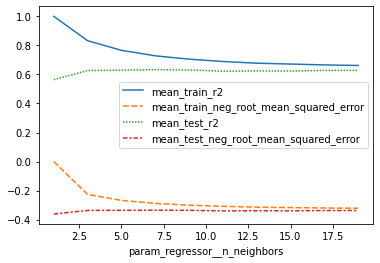


Résultat pour la cible TotalGHGEmissions:
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__n_neighbors': 9}

Performance en généralisation sur le jeu de test : 0.759
Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:
R2: 0.731 +/- 0.005
RMSE: -0.325 +/- 0.005

Scores moyens sur le jeu de validation, avec le meilleur modèle:
R2: 0.668 +/- 0.038
RMSE: -0.361 +/- 0.031


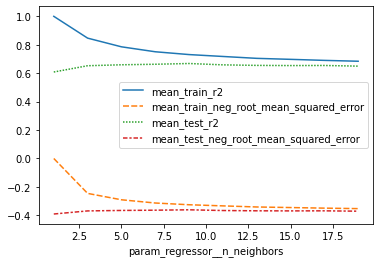

In [7]:
from sklearn.neighbors import KNeighborsRegressor
models = {'SiteEnergyUse_log':SEUmodel, 'TotalGHGEmissions_log':GHGmodel}

for k, m in models.items():
    target = k
    target_name = target.split('_')[0]
    m1, features = modelpreparation(m)
    print("\nRésultat pour la cible {}:".format(target_name))
    
    # Valeurs possibles du nombre de plus proches voisins
    params = {"n_neighbors" : [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}
    
    # Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
    score = ('r2', 'neg_root_mean_squared_error')
    
    # modèle
    model = KNeighborsRegressor()
    
    # chargement du modèle
    gspipeline = crossval_GS(target, features, m1, params, model, score)
    
    # DataFrame des résultats de la validation croisée
    cvresults = print_cvresults(score, gspipeline, params)
    
    # Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
    plot_traintestscores(cvresults, score, axis_scale="linear", plot_param=list(params.keys()))

kNN permet de régler la complexité du modèle et a permis ainsi une amélioration significative des scores d'entraînement et de test, mais le score final 0.61 +/ 0.06 reste modeste. On va essayer le même type d'analyse avec RandomForestRegressor et ainsi déterminer si il est possible d'avoir un meilleur compromis biais-variance, et on va essayer de diminuer la taille du modèle grâce à l'attribut "feature_importances_" permettant, en association avec SelectFromModel de sélectionner les variables pertinentes. Comme RandomForestRegressor.feature_importances_ souffre de potentiels biais (notamment envers les variables avec un grand nombre de modalités), on va également inspecter l'importance des différentes variables grâce à sklearn.inspection.permutation_importance. On en déduira deux modèles, qu'on pourra alors comparer pour sélectionner le meilleur.

## III.4 Régression polynomiale et sélection de prédicteurs avec Lasso

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__alpha': 0.0071968567300115215}

Performance en généralisation sur le jeu de test : 0.652
Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:
R2: 0.772 +/- 0.005
RMSE: -0.295 +/- 0.002

Scores moyens sur le jeu de validation, avec le meilleur modèle:
R2: 0.741 +/- 0.015
RMSE: -0.313 +/- 0.009


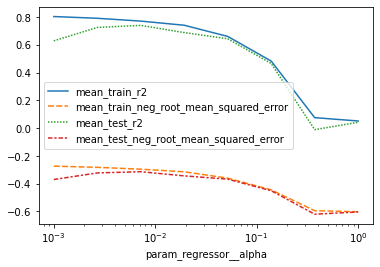

In [8]:
##### from sklearn.preprocessing import PolynomialFeatures

SEUmodel3 = pd.read_csv("./SEUmodel3.csv")
GHGmodel3 = pd.read_csv("./GHGmodel3.csv")

poly = PolynomialFeatures(degree=2)

## Le nombre rapidement croissant de prédicteurs lors de la transformation polynomiale impose de réduire le 
## nombre de variables en entrée. On utilise le jeu de données SEUmodel3.csv, dans lequel les modalités de 
## YearBuilt sont au nombre de 2 (12 dans le cas de SEUmodel2.csv)
m1, features = modelpreparation(SEUmodel3)

# colonnes sur lesquelles appliquer l'ACP
pca_cols = ["PropertyGFATotal", 
            "PropertyGFAParking",
            "PropertyGFABuilding(s)",
            "LargestPropertyUseTypeGFA",
            "SecondLargestPropertyUseTypeGFA",
            "ThirdLargestPropertyUseTypeGFA"]

#features = pca_cols + ["Electricity_ratio",
#                       "NumberofFloors",
#                       "PrimaryPropertyType", 
                       #"LargestPropertyUseType", 
                       #"SecondLargestPropertyUseType", 
                       #"YearBuilt"
 #                     ]

# Séparation prédicteurs - cible, entraînement-test. Préparation du pipeline
X = m1[features]
y = m1[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Pipeline #####
# One-hot encoding of categorical variable
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
# Standard scaling of numerical features
numeric_transformer = StandardScaler()  
        
# ACP sur les variables quantitatives
#pca = PCA(n_components=4)
    
std_pca_transformer = make_pipeline(StandardScaler(),
                                    PCA(n_components=4))  



# Récupération des indices correspondant aux variables sur lesquelles on réalise l'ACP dans le tableau
# numpy créé après preprocessing1. Le tableau numpy est en effet réorganisé lors du preprocessing avec les
# colonnes numeriques d'abord, puis les colonnes créées lors de l'ACP et enfin les colonnes catégorielles
X_train_only_numeric = X_train.select_dtypes(include=['float64'])
pca_index = [X_train_only_numeric.columns.get_loc(c) for c in pca_cols]
    
        
preprocessor1 = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="category")),
    ('std_pca', std_pca_transformer, pca_cols),
    ('cat', categorical_transformer, selector(dtype_include="category"))],
                                  remainder='passthrough')

preprocessor2 = ColumnTransformer(transformers=[('drop_pca', 'drop', pca_index)], 
                                  remainder='passthrough'
                                 )

# Les indices de colonnes sur lesquelles opérer la transformation vont de 0 au nombre de colonnes dans le
# numpy.array créé aprè preprocessor2.
cat_var = X_train.dtypes[X_train.dtypes=='category'].index

# nombre total de modalités, i.e. de nouvelles colonnes créées par dummy encoding
nb_dummycols = X_train[cat_var].nunique().sum()

# nombre de colonnes dans X_train après preprocessor2
nb_cols = int(len(features)-len(cat_var)+nb_dummycols-len(pca_cols)+4)

preprocessor3 = ColumnTransformer(transformers=[('polyfeat', poly, np.arange(0, nb_cols))])

reg = Pipeline(steps=[('preprocessor1', preprocessor1), 
                      ('preprocessor2', preprocessor2),
                      ('preprocessor3', preprocessor3),
                      ('regressor', Lasso(tol=1e-4, max_iter=1e5))
                     ])

######

# Valeurs possibles du paramètre alpha
params = {"alpha" : np.logspace(-3, 0, 8)}

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# modèle
#model = Lasso(tol=1e-4, max_iter=1e5)

# Nested cross-validation
inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)

# Hyperparamètre à optimiser
param_grid = {}
for key, values in params.items():
    param_grid["regressor__"+key] = values
    
    
# Régression avec sélection d'hyperparamètre par validation croisée
regr = GridSearchCV(
reg,            # modèle
param_grid,     # hyperparamètres à tester
cv=inner_cv,    # nombre de folds de validation croisée
scoring=score,   # score à optimiser
return_train_score=True,
refit='r2',
)

# Optimiser cet estimateur sur le jeu d'entraînement
regr.fit(X_train, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(regr.best_params_)

# Performance en généralisation du meilleur modèle sur le set de test
y_pred = regr.predict(X_test)
print("\nPerformance en généralisation sur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))


# DataFrame des résultats de la validation croisée
cvresults = print_cvresults(score, regr, params)

# Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
plot_traintestscores(cvresults, score, plot_param=list(params.keys()))

## III.5 Feature importance avec RandomForest

On reprend le jeu de données initial pour déterminer la valeur optimale de l'hyperparamètre n_estimators

Résultat pour la cible SiteEnergyUse:


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 100}

Performance en généralisation sur le jeu de test : 0.835
Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:
R2: 0.971 +/- 0.001
RMSE: -0.095 +/- 0.001

Scores moyens sur le jeu de validation, avec le meilleur modèle:
R2: 0.795 +/- 0.030
RMSE: -0.250 +/- 0.029


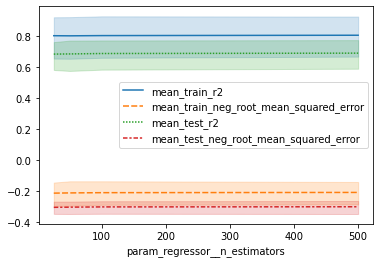

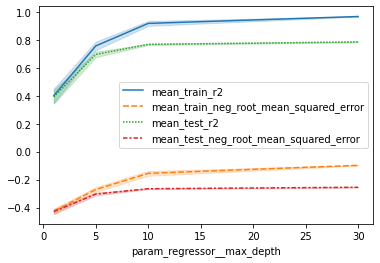

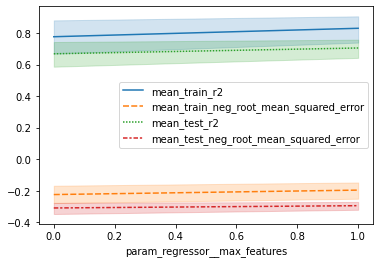

Résultat pour la cible TotalGHGEmissions:


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__max_depth': None, 'regressor__max_features': 'auto', 'regressor__n_estimators': 25}

Performance en généralisation sur le jeu de test : 0.844
Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:
R2: 0.972 +/- 0.001
RMSE: -0.105 +/- 0.002

Scores moyens sur le jeu de validation, avec le meilleur modèle:
R2: 0.820 +/- 0.031
RMSE: -0.265 +/- 0.028


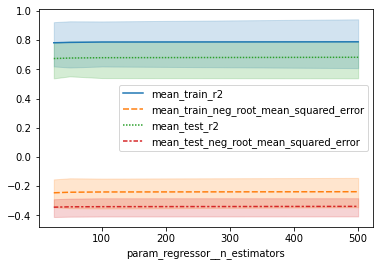

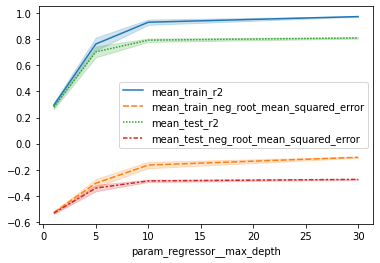

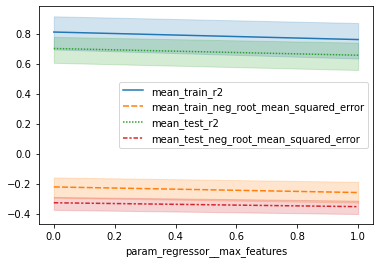

In [9]:
models = {'SiteEnergyUse_log':SEUmodel, 'TotalGHGEmissions_log':GHGmodel}

for k, m in models.items():
    target = k
    target_name = target.split('_')[0]
    m1, features = modelpreparation(m)
    print("Résultat pour la cible {}:".format(target_name))
    
    # Valeurs possibles des hyperparamètres
    params = {"n_estimators" : [25,50,100, 500], 
              "max_depth" : [None, 1, 5, 10, 30], 
              "max_features" : ['auto', "sqrt"]}

    # Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
    score = ('r2', 'neg_root_mean_squared_error')

    # modèle
    model = RandomForestRegressor(oob_score=True)

    # Preprocessing et fit du modèle
    gspipeline = crossval_GS(target, features, m1, params, model, score)

    # DataFrame des résultats de la validation croisée
    cvresults = print_cvresults(score, gspipeline, params)
    
    # Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
    plot_traintestscores(cvresults, score, plot_param=list(params.keys()), axis_scale='linear')

Recherche d'un modèle plus simple à l'aide de deux méthodes:
* RandomForestRegressor.feature_importances_
* sklearn.inspection.permutation_importance

Résultat pour la cible SiteEnergyUse:


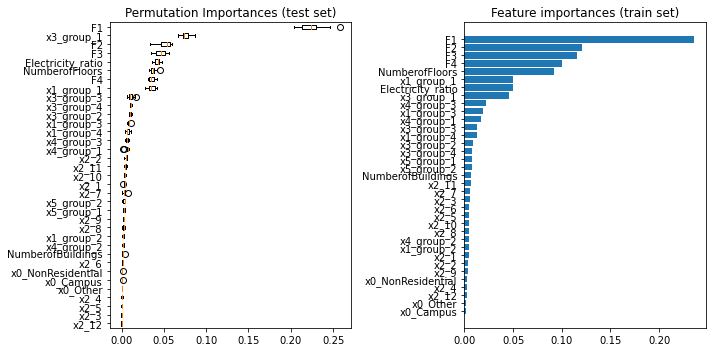

Résultat pour la cible TotalGHGEmissions:


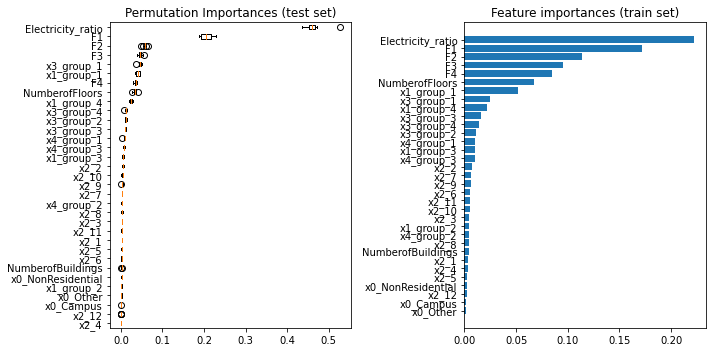

In [10]:
from sklearn.inspection import permutation_importance

for k, m in models.items():
    target = k
    target_name = target.split('_')[0]
    m1, features = modelpreparation(m)
    print("Résultat pour la cible {}:".format(target_name))

    # Séparation prédicteurs - cible
    X = m1[features]
    y = m1[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # Permutation importance
    # Pipeline de transformation du dataset uniquement
    transf_pipeline = create_pipeline(_, X_train)
    X_train_transf = transf_pipeline.fit_transform(X_train)
    X_test_transf = transf_pipeline.transform(X_test)
    
    # Création d'un nouvel estimateurs
    rfr = RandomForestRegressor(n_estimators=500, max_depth=30, max_features='sqrt', oob_score=True)
    rfr.fit(X_train_transf, y_train)
    
    result = permutation_importance(rfr, X_test_transf, y_test, n_repeats=10, random_state=0)
    sorted_idx = result.importances_mean.argsort()
    
    # Création du pipeline constitué d'une étape de normalisation, d'ACP et de l'estimateur. 
    rfr1 = RandomForestRegressor(n_estimators=500, max_depth=30, max_features='sqrt', oob_score=True)
    reg = create_pipeline(rfr1, X_train, regressor=True)
    
    # Fit transform
    reg.fit(X_train, y_train)
    
    # Feature importances
    feat_importances = reg.named_steps['regressor'].feature_importances_
    
    # Affichage des résultats dans un dataframe
    # Les colonnes de type numérique (non catégoriel) du dataframe avant transformation
    base_cols = X_train.dtypes[X_train.dtypes!='category'].index
    
    # Colonnes correspondant au dataframe transformé
    onehot_cols = transf_pipeline.named_steps['preprocessor1'].named_transformers_['cat'].get_feature_names()
    updated_cols = pd.Index([c for c in base_cols if not c in pca_cols])
    labels = np.concatenate((updated_cols,
                             ['F1', 'F2', 'F3', 'F4'], 
                             onehot_cols,
                             ))
    labels = pd.Index(labels)    
    feature_importances = pd.DataFrame(data={"feature importance":np.abs(feat_importances)},
                                       index=labels).sort_values(by=['feature importance'],
                                                                 ascending=False)
    
    # Affichage des features par ordre d'importance
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    ax1.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=labels[sorted_idx])
    ax1.set_title("Permutation Importances (test set)")
    
    f = feature_importances["feature importance"]
    ax2.barh(f.index, f)
    ax2.set_title("Feature importances (train set)")
    ax2.invert_yaxis()
    fig.tight_layout()
    plt.show()

Les deux méthodes donnent des résultats remarquablement similaires. De plus, cette fois-ci un grand nombre de variables sont "annulées", ce qui permet d'effectuer une sélection intéressante.
On va réutiliser RandomForestRegressor sur une sous-sélection basée sur les résultats obtenus, avec le meilleur hyperparamètre (ici on choisit 100 car on n'observe pas d'amélioration significative des performances avec un nombre d'estimateurs plus grand).

In [11]:
# Implémentation de RandomForestRegressor sur les features sélectionnées uniquement

rfr2 = RandomForestRegressor(n_estimators=500, max_depth=30, max_features='sqrt', oob_score=True)
select = SelectFromModel(estimator=rfr, threshold=0.01).fit(X_train_transf, y_train)
print("Variables sélectionnées:")
print(feature_importances[feature_importances["feature importance"]>1e-2].index.values)
X_train_sel = select.transform(X_train_transf)
X_test_sel = select.transform(X_test_transf)
rfr2.fit(X_train_sel, y_train)
print("score R2 sur le jeu de test avec la sélection de variables: {:.3f}".format(rfr2.score(X_test_sel, y_test)))

Variables sélectionnées:
['Electricity_ratio' 'F1' 'F2' 'F3' 'F4' 'NumberofFloors' 'x1_group_1'
 'x3_group_1' 'x1_group_4' 'x3_group_3' 'x3_group_4' 'x3_group_2'
 'x4_group_1' 'x1_group_3' 'x4_group_3']
score R2 sur le jeu de test avec la sélection de variables: 0.840


# IV Choix du modèle

On reprend tous les modèles explorés avec les hyperparamètres déterminés par validation croisée et on les fait tourner sur le jeu d'entraînement pour comparer les scores et les temps de fit/prediction. On choisira lemodèle qui représente le meilleur compromis entre ces grandeurs.

Linear Regression
train time: 0.068s
test time:  0.016s
score:   0.589

Lasso
train time: 0.068s
test time:  0.015s
score:   0.582

kNN
train time: 0.078s
test time:  0.059s
score:   0.675

Random Forest
train time: 1.496s
test time:  0.044s
score:   0.786

Random Forest with feature selection
train time: 1.410s
test time:  0.026s
score:   0.789



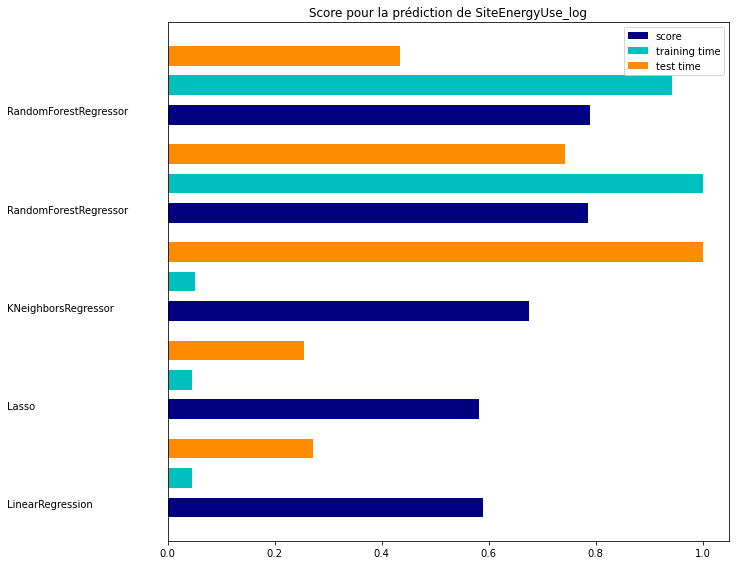

Linear Regression
train time: 0.085s
test time:  0.015s
score:   0.659

Lasso
train time: 0.054s
test time:  0.015s
score:   0.654

kNN
train time: 0.058s
test time:  0.056s
score:   0.710

Random Forest
train time: 1.403s
test time:  0.039s
score:   0.858

Random Forest with feature selection
train time: 1.368s
test time:  0.027s
score:   0.860



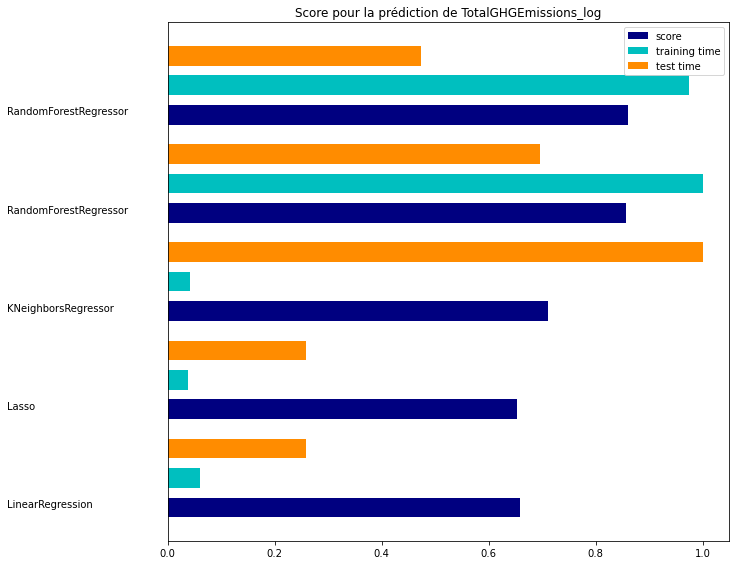

In [12]:
models = {'SiteEnergyUse_log':SEUmodel, 'TotalGHGEmissions_log':GHGmodel}
from time import time
def benchmark(reg, X_train, X_test, y_train, y_test):

    t0 = time()
    reg.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = reg.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = r2_score(y_test, pred)
    print("score:   %0.3f" % score)

    print()
    
    try:
        reg_descr = str(reg.named_steps['regressor']).split('(')[0]
    except:
        reg_descr = str(reg).split('(')[0]
    
    return reg_descr, score, train_time, test_time

for k, m in models.items():
    target = k
    target_name = target.split('_')[0]
    m1, features = modelpreparation(m)

    X = m1[features]
    y = m1[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    results = []
    
    for regr, name in (
            (LinearRegression(), "Linear Regression"),
            (Lasso(alpha=2.15e-3, max_iter=1e5), "Lasso"),
            (KNeighborsRegressor(n_neighbors=9), "kNN"),
            (RandomForestRegressor(), "Random Forest")):
        reg = create_pipeline(regr, X_train, regressor=True)
        print('=' * 80)
        print(name)
        results.append(benchmark(reg, X_train, X_test, y_train, y_test))
    

    rfr2 = RandomForestRegressor()
    rfr = RandomForestRegressor()
    transf_pipe = create_pipeline(_, X_train)
    X_train_transf = transf_pipe.fit_transform(X_train)
    X_test_transf = transf_pipe.transform(X_test)

    select = SelectFromModel(estimator=rfr, threshold=0.01).fit(X_train_transf, y_train)
    X_train_sel = select.transform(X_train_transf)
    X_test_sel = select.transform(X_test_transf)
    print('=' * 80)
    print('Random Forest with feature selection')
    results.append(benchmark(rfr2, X_train_transf, X_test_transf, y_train, y_test))


    indices = np.arange(len(results))
    results = [[x[i] for x in results] for i in range(4)]
    
    reg_names, score, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)
    
    plt.figure(figsize=(12, 8))
    plt.title(f"Score pour la prédiction de {target}")
    plt.barh(indices, score, .2, label="score", color='navy')
    plt.barh(indices + .3, training_time, .2, label="training time",
             color='c')
    plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    
    for i, c in zip(indices, reg_names):
        plt.text(-.3, i, c)
    
    plt.show()

RandomForestRegressor est de loin le meilleur algorithme. Sélectionner les features n'apporte qu'une amélioration modeste au temps d'entraînement, néanmoins grâce à des performances à peines entamées on décide de choisir ce modèle pour réaliser les prédictions de SiteEnergyUse, puis TotalGHGEmissions.

# V ENERGYSTARScore

Avant de passer à la prédiction de TotalGHGEmissions, on cherche à évaluer l'importance de ENERGYSTARScore pour la prédiction. Comme vu lors de l'analyse exploratoire, ENERGYSTARScore est corrélée (faiblement) aux valeurs moyennes de SourceEUIWN, GHGEmissionsIntensity, et ces dernières sont corrélées à TotalGHGEmissions via PropertyGFABuilding(s). On souhaite maintenant quantifier cette corrélation.

TotalGHGEmissions (log) vs ENERGYSTARScore:
R2 sur le jeu de données: 0.020


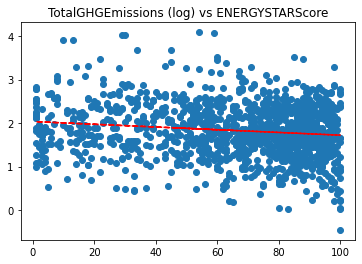

GHGEmissionsIntensity vs ENERGYSTARScore:
R2 sur le jeu de données: 0.119


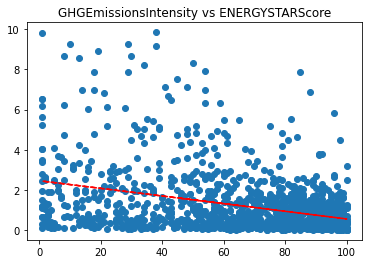

GHGEmissionsIntensity moyenne vs ENERGYSTARScore:
R2 sur le jeu de données: 0.371


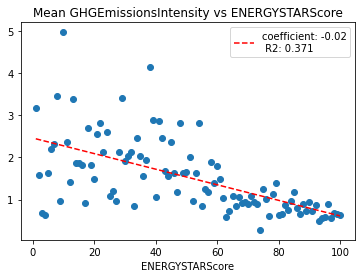

In [13]:
# prédicteurs
escmodel = GHGmodel.copy()
escmodel.dropna(subset=["ENERGYSTARScore"], inplace=True)

features = "ENERGYSTARScore"
target = "TotalGHGEmissions_log"

X = escmodel[features].values.reshape(-1, 1)
y = escmodel[target].values

# Régression linéaire sur les données brutes
lr = LinearRegression()
lr.fit(X, y)
print("TotalGHGEmissions (log) vs ENERGYSTARScore:")
print("R2 sur le jeu de données: {:.3f}".format(lr.score(X,y)))
coef = lr.coef_
intercept = lr.intercept_

fig, ax = plt.subplots()
ax.scatter(x=escmodel["ENERGYSTARScore"], y=escmodel["TotalGHGEmissions_log"])
ax.plot(escmodel["ENERGYSTARScore"], intercept + escmodel["ENERGYSTARScore"]*coef, 'r--')
ax.set_title("TotalGHGEmissions (log) vs ENERGYSTARScore")
plt.show()

features = "ENERGYSTARScore"
target = "GHGEmissionsIntensity"

X = escmodel[features].values.reshape(-1, 1)
y = escmodel[target].values

# Régression linéaire sur les données brutes
lr = LinearRegression()
lr.fit(X, y)
print("="*80)
print("GHGEmissionsIntensity vs ENERGYSTARScore:")
print("R2 sur le jeu de données: {:.3f}".format(lr.score(X,y)))
coef = lr.coef_
intercept = lr.intercept_

fig, ax = plt.subplots()
ax.scatter(x=escmodel["ENERGYSTARScore"], y=escmodel["GHGEmissionsIntensity"])
ax.plot(escmodel["ENERGYSTARScore"], intercept + escmodel["ENERGYSTARScore"]*coef, 'r--')
ax.set_title("GHGEmissionsIntensity vs ENERGYSTARScore")
plt.show()

# Régression linéaire sur les valeurs moyennes de GHGEmissionsIntensity pour chaque valeur de ENERGYSTARScore
X = escmodel.groupby(features).mean()[target].index.to_numpy().reshape(-1, 1)
y = escmodel.groupby(features).mean()[target].values

lr.fit(X, y)
print("="*80)
print("GHGEmissionsIntensity moyenne vs ENERGYSTARScore:")
score = lr.score(X,y)
print("R2 sur le jeu de données: {:.3f}".format(score))
coef = lr.coef_
intercept = lr.intercept_

indices = escmodel.groupby(features).mean()[target].index.values
fig, ax = plt.subplots()
ax.scatter(escmodel.groupby(features).mean()[target].index.to_numpy(),  y)
ax.plot(indices, intercept + indices*coef, 'r--', label="coefficient: {:.2f}\n R2: {:.3f}".format(coef[0], score))
ax.set_title("Mean GHGEmissionsIntensity vs ENERGYSTARScore")
ax.set_xlabel("ENERGYSTARScore")
ax.legend()
plt.show()

ENERGYSTARScore est clairement corrélé aux _valeurs moyennes_ de GHGEmissionsIntensity, plus qu'aux valeurs "brutes". Le coefficient R2 existant etre TotalGHGEmissions_log et ENERGYSTARScore (R2=0.02) indique une absence de corrélation (linéaire) entre les deux variables. ENERGYSTARScore n'est donc pas d'un grand intérêt pour prédire TotalGHGEmissions.

# VI Prédiction de TotalGHGEmissions

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__max_depth': 10, 'regressor__max_features': 'auto', 'regressor__n_estimators': 25}

Performance en généralisation sur le jeu de test : 0.991
Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:
R2: 0.998 +/- 0.000
RMSE: -0.025 +/- 0.002

Scores moyens sur le jeu de validation, avec le meilleur modèle:
R2: 0.991 +/- 0.003
RMSE: -0.059 +/- 0.011


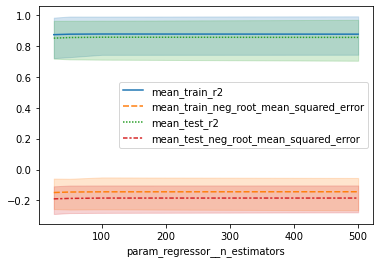

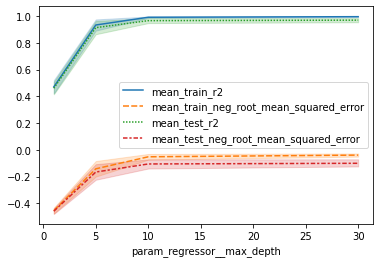

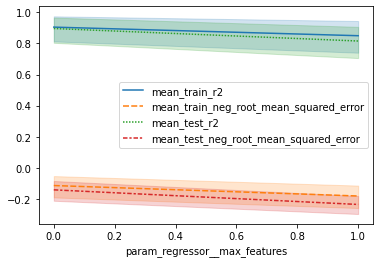

In [14]:
m1, features = modelpreparation(GHGmodel)

pca_cols = ["PropertyGFATotal", 
            "PropertyGFAParking",
            "PropertyGFABuilding(s)",
            "LargestPropertyUseTypeGFA",
            "SecondLargestPropertyUseTypeGFA",
            "ThirdLargestPropertyUseTypeGFA"]

features = ["SiteEnergyUse_log", "Electricity_ratio", "NumberofFloors", 
            "PrimaryPropertyType", "LargestPropertyUseType"] + pca_cols

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# hyperparamètre
params = {"n_estimators" : [25,50,100, 500], 
              "max_depth" : [None, 1, 5, 10, 30], 
              "max_features" : ['auto', "sqrt"]}
# modèle
model = RandomForestRegressor()

# Preprocessing et fit du modèle
gspipeline = crossval_GS("TotalGHGEmissions_log", features, m1, params, model, score)

# DataFrame des résultats de la validation croisée
cvresults = print_cvresults(score, gspipeline, params)

# Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
plot_traintestscores(cvresults, score, plot_param=list(params.keys()), axis_scale='linear')

A condition d'utiliser SiteEnergyUse (après application du log et de StandardScaler qui plus est), on obtient des résultats très satisfaisant pour TotalGHGEmissions. On va donc explorer un modèle qui combinera la prédiction sur SiteEnergyUse dans un premier temps, et se servira de cette prédiction pour prédire TotalGHGEmissions.

In [20]:
m1, features = modelpreparation(SEUmodel)


pca_cols = ["PropertyGFATotal", 
            "PropertyGFAParking",
            "PropertyGFABuilding(s)",
            "LargestPropertyUseTypeGFA",
            "SecondLargestPropertyUseTypeGFA",
            "ThirdLargestPropertyUseTypeGFA"]

# D'abord, prédiction de SiteEnergyUse
features = pca_cols + ["Electricity_ratio", "NumberofFloors", "PrimaryPropertyType",
                       "LargestPropertyUseType"]
X = m1[features]
y = m1[["SiteEnergyUse_log", "TotalGHGEmissions_log"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5) # split à 50% et non l'habituel 80-20
rfr = RandomForestRegressor(n_estimators=500, max_depth=30, max_features='sqrt')
SEUpipeline = create_pipeline(rfr, X_train, regressor=True)

SEUpipeline.fit(X_train, y_train["SiteEnergyUse_log"])
seu_predictions = SEUpipeline.predict(X_test)
seu_score = r2_score(y_test["SiteEnergyUse_log"], seu_predictions)
X_test.loc[:, "SEU_log_pred"] = seu_predictions

# Prediction de TotalGHGEmissions
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_test, 
                                                                            y_test["TotalGHGEmissions_log"],
                                                                            test_size=0.2)
rfr1 = RandomForestRegressor(n_estimators=25, max_depth=10, max_features='auto')
GHGpipeline = create_pipeline(rfr1, X_train_final, regressor=True)
GHGpipeline.fit(X_train_final, y_train_final)
ghg_predictions = GHGpipeline.predict(X_test_final)
ghg_score = r2_score(y_test_final, ghg_predictions)

print("Performance en prédiction sur le jeu de test:")
print("R2 pour la prédiction de SiteEnergyUse_log: {:.3f}".format(seu_score))
print("R2 pour la prédiction de TotalGHGEmissions_log: {:.3f}".format(ghg_score))

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Performance en prédiction sur le jeu de test:
R2 pour la prédiction de SiteEnergyUse_log: 0.776
R2 pour la prédiction de TotalGHGEmissions_log: 0.830


On parvient à une prédiction de 77% pour SiteEnergyUse, et d'environ 83% pour TotalGHGEmissions.

#### Modèle non séquentiel

In [21]:
models = {'SiteEnergyUse_log':SEUmodel, 'TotalGHGEmissions_log':GHGmodel}
for k, m in models.items():
    target = k
    target_name = target.split('_')[0]
    m1, features = modelpreparation(m)
    model = RandomForestRegressor(n_estimators=500, max_depth=30, max_features='sqrt')
    print("\nRésultat pour la cible {}:".format(target_name))
    print(crossval_noGS(target, features, m1, model))
    print("="*80)


Résultat pour la cible SiteEnergyUse:
         fit_time  score_time   test_r2  train_r2
1        2.794997    0.132941  0.869659  0.975482
0        2.794700    0.133287  0.847636  0.977352
2        2.764711    0.134526  0.823618  0.977812
3        2.616002    0.132681  0.820884  0.977151
4        2.609864    0.292935  0.807773  0.978205
moyenne  2.716055    0.165274  0.833914  0.977201

Résultat pour la cible TotalGHGEmissions:
         fit_time  score_time   test_r2  train_r2
1        2.559534    0.132434  0.869499  0.978457
0        2.653367    0.131397  0.867909  0.978462
4        2.560561    0.130748  0.859832  0.978867
3        2.574984    0.132565  0.856403  0.979986
2        2.536444    0.130617  0.832500  0.980990
moyenne  2.576978    0.131552  0.857228  0.979352


# Autre jeu de données

In [ ]:
SEUmodel2 = pd.read_csv("./SEUmodel2.csv")
GHGmodel2 = pd.read_csv("./GHGmodel2.csv")
models = {'SiteEnergyUse_log':SEUmodel2, 'TotalGHGEmissions_log':GHGmodel2}

In [ ]:
SEUmodel2.info()

In [ ]:
GHGmodel2.info()

In [ ]:
for k, m in models.items():
    target = k
    target_name = target.split('_')[0]
    m1, features = modelpreparation(m)
    model = LinearRegression()
    print("\nRésultat pour la cible {}:".format(target_name))
    print(crossval_noGS(target, features, m1, model))
    print("="*80)

In [ ]:
for k, m in models.items():
    target = k
    target_name = target.split('_')[0]
    m1, features = modelpreparation(m)
    print("\nRésultat pour la cible {}:".format(target_name))
    
    # Valeurs possibles du nombre de plus proches voisins
    params = {"n_neighbors" : [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}
    
    # Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
    score = ('r2', 'neg_root_mean_squared_error')
    
    # modèle
    model = KNeighborsRegressor()
    
    # chargement du modèle
    gspipeline = crossval_GS(target, features, m1, params, model, score)
    
    # DataFrame des résultats de la validation croisée
    cvresults = print_cvresults(score, gspipeline, params)
    
    # Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
    plot_traintestscores(cvresults, score, axis_scale="linear", plot_param=["n_neighbors"])

In [ ]:
for k, m in models.items():
    target = k
    target_name = target.split('_')[0]
    m1, features = modelpreparation(m)
    print("Résultat pour la cible {}:".format(target_name))
    
    # Valeurs possibles des hyperparamètres
    params = {"n_estimators" : [25,50,100, 500], 
              "max_depth" : [None, 1, 5, 10, 30], 
              "max_features" : [None, "sqrt"]}

    # Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
    score = ('r2', 'neg_root_mean_squared_error')

    # modèle
    model = RandomForestRegressor(oob_score=True)

    # Preprocessing et fit du modèle
    gspipeline = crossval_GS(target, features, m1, params, model, score)

    # DataFrame des résultats de la validation croisée
    cvresults = print_cvresults(score, gspipeline, params)
    
    # Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
    plot_traintestscores(cvresults, score, plot_param=["n_estimators", "max_depth"], axis_scale='linear')

In [ ]:
from sklearn.inspection import permutation_importance

for k, m in models.items():
    target = k
    target_name = target.split('_')[0]
    m1, features = modelpreparation(m)
    print("Résultat pour la cible {}:".format(target_name))

    # Séparation prédicteurs - cible
    X = m1[features]
    y = m1[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # Permutation importance
    # Pipeline de transformation du dataset uniquement
    transf_pipeline = create_pipeline(_, X_train)
    X_train_transf = transf_pipeline.fit_transform(X_train)
    X_test_transf = transf_pipeline.transform(X_test)
    
    # Création d'un nouvel estimateurs
    rfr = RandomForestRegressor(n_estimators=500, max_depth=30, max_features='sqrt', oob_score=True)
    rfr.fit(X_train_transf, y_train)
    
    result = permutation_importance(rfr, X_test_transf, y_test, n_repeats=10, random_state=0)
    sorted_idx = result.importances_mean.argsort()
    
    # Création du pipeline constitué d'une étape de normalisation, d'ACP et de l'estimateur. 
    rfr1 = RandomForestRegressor(n_estimators=500, max_depth=30, max_features='sqrt', oob_score=True)
    reg = create_pipeline(rfr1, X_train, regressor=True)
    
    # Fit transform
    reg.fit(X_train, y_train)
    
    # Feature importances
    feat_importances = reg.named_steps['regressor'].feature_importances_
    
    # Affichage des résultats dans un dataframe
    # Les colonnes de type numérique (non catégoriel) du dataframe avant transformation
    base_cols = X_train.dtypes[X_train.dtypes!='category'].index
    
    # Colonnes correspondant au dataframe transformé
    onehot_cols = transf_pipeline.named_steps['preprocessor1'].named_transformers_['cat'].get_feature_names()
    updated_cols = pd.Index([c for c in base_cols if not c in pca_cols])
    labels = np.concatenate((updated_cols,
                             ['F1', 'F2', 'F3', 'F4'], 
                             onehot_cols,
                             ))
    labels = pd.Index(labels)    
    feature_importances = pd.DataFrame(data={"feature importance":np.abs(feat_importances)},
                                       index=labels).sort_values(by=['feature importance'],
                                                                 ascending=False)
    
    # Affichage des features par ordre d'importance
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    ax1.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=labels[sorted_idx])
    ax1.set_title("Permutation Importances (test set)")
    
    f = feature_importances["feature importance"]
    ax2.barh(f.index, f)
    ax2.set_title("Feature importances (train set)")
    ax2.invert_yaxis()
    fig.tight_layout()
    plt.show()

In [ ]:
# Implémentation de RandomForestRegressor sur les features sélectionnées uniquement

rfr2 = RandomForestRegressor(n_estimators=500, max_depth=30, max_features='sqrt', oob_score=True)
select = SelectFromModel(estimator=rfr, threshold=0.01).fit(X_train_transf, y_train)
print("Variables sélectionnées:")
print(feature_importances[feature_importances["feature importance"]>1e-2].index.values)
X_train_sel = select.transform(X_train_transf)
X_test_sel = select.transform(X_test_transf)
rfr2.fit(X_train_sel, y_train)
print("score R2 sur le jeu de test avec la sélection de variables: {:.3f}".format(rfr2.score(X_test_sel, y_test)))

In [ ]:
m1, features = modelpreparation(SEUmodel2)


pca_cols = ["PropertyGFATotal", 
            "PropertyGFAParking",
            "PropertyGFABuilding(s)",
            "LargestPropertyUseTypeGFA",
            "SecondLargestPropertyUseTypeGFA",
            "ThirdLargestPropertyUseTypeGFA"]

# D'abord, prédiction de SiteEnergyUse
features = pca_cols + ["Electricity_ratio", "NumberofFloors", "PrimaryPropertyType",
                       "LargestPropertyUseType"]
X = m1[features]
y = m1[["SiteEnergyUse_log", "TotalGHGEmissions_log"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5) # split à 50% et non l'habituel 80-20
rfr = RandomForestRegressor(n_estimators=500, max_depth=30, max_features='sqrt')
SEUpipeline = create_pipeline(rfr, X_train, regressor=True)

SEUpipeline.fit(X_train, y_train["SiteEnergyUse_log"])
seu_predictions = SEUpipeline.predict(X_test)
seu_score = r2_score(y_test["SiteEnergyUse_log"], seu_predictions)
X_test.loc[:, "SEU_log_pred"] = seu_predictions

# Prediction de TotalGHGEmissions
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_test, 
                                                                            y_test["TotalGHGEmissions_log"],
                                                                            test_size=0.2)
rfr1 = RandomForestRegressor(n_estimators=500, max_depth=30, max_features='sqrt')
GHGpipeline = create_pipeline(rfr1, X_train_final, regressor=True)
GHGpipeline.fit(X_train_final, y_train_final)
ghg_predictions = GHGpipeline.predict(X_test_final)
ghg_score = r2_score(y_test_final, ghg_predictions)

print("Performance en prédiction sur le jeu de test:")
print("R2 pour la prédiction de SiteEnergyUse_log: {:.3f}".format(seu_score))
print("R2 pour la prédiction de TotalGHGEmissions_log: {:.3f}".format(ghg_score))

In [ ]:
models = {'SiteEnergyUse_log':SEUmodel2, 'TotalGHGEmissions_log':GHGmodel2}
for k, m in models.items():
    target = k
    target_name = target.split('_')[0]
    m1, features = modelpreparation(m)
    model = RandomForestRegressor(n_estimators=500, max_depth=30, max_features='sqrt')
    print("\nRésultat pour la cible {}:".format(target_name))
    print(crossval_noGS(target, features, m1, model))
    print("="*80)

In [ ]:
# prédicteurs
escmodel = GHGmodel2.copy()
escmodel.dropna(subset=["ENERGYSTARScore"], inplace=True)

features = "ENERGYSTARScore"
target = "TotalGHGEmissions_log"

X = escmodel[features].values.reshape(-1, 1)
y = escmodel[target].values

# Régression linéaire sur les données brutes
lr = LinearRegression()
lr.fit(X, y)
print("TotalGHGEmissions (log) vs ENERGYSTARScore:")
print("R2 sur le jeu de données: {:.3f}".format(lr.score(X,y)))
coef = lr.coef_
intercept = lr.intercept_

fig, ax = plt.subplots()
ax.scatter(x=escmodel["ENERGYSTARScore"], y=escmodel["TotalGHGEmissions_log"])
ax.plot(escmodel["ENERGYSTARScore"], intercept + escmodel["ENERGYSTARScore"]*coef, 'r--')
ax.set_title("TotalGHGEmissions (log) vs ENERGYSTARScore")
plt.show()

features = "ENERGYSTARScore"
target = "GHGEmissionsIntensity"

X = escmodel[features].values.reshape(-1, 1)
y = escmodel[target].values

# Régression linéaire sur les données brutes
lr = LinearRegression()
lr.fit(X, y)
print("="*80)
print("GHGEmissionsIntensity vs ENERGYSTARScore:")
print("R2 sur le jeu de données: {:.3f}".format(lr.score(X,y)))
coef = lr.coef_
intercept = lr.intercept_

fig, ax = plt.subplots()
ax.scatter(x=escmodel["ENERGYSTARScore"], y=escmodel["GHGEmissionsIntensity"])
ax.plot(escmodel["ENERGYSTARScore"], intercept + escmodel["ENERGYSTARScore"]*coef, 'r--')
ax.set_title("GHGEmissionsIntensity vs ENERGYSTARScore")
plt.show()

# Régression linéaire sur les valeurs moyennes de GHGEmissionsIntensity pour chaque valeur de ENERGYSTARScore
X = escmodel.groupby(features).mean()[target].index.to_numpy().reshape(-1, 1)
y = escmodel.groupby(features).mean()[target].values

lr.fit(X, y)
print("="*80)
print("GHGEmissionsIntensity moyenne vs ENERGYSTARScore:")
score = lr.score(X,y)
print("R2 sur le jeu de données: {:.3f}".format(score))
coef = lr.coef_
intercept = lr.intercept_

indices = escmodel.groupby(features).mean()[target].index.values
fig, ax = plt.subplots()
ax.scatter(escmodel.groupby(features).mean()[target].index.to_numpy(),  y)
ax.plot(indices, intercept + indices*coef, 'r--', label="coefficient: {:.2f}\n R2: {:.3f}".format(coef[0], score))
ax.set_title("Mean GHGEmissionsIntensity vs ENERGYSTARScore")
ax.set_xlabel("ENERGYSTARScore")
ax.legend()
plt.show()